In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict,train_test_split, StratifiedKFold 
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Concatenate, Bidirectional, Embedding
from tensorflow.keras.layers import LSTM, BatchNormalization, GRU, Masking
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal, glorot_normal, glorot_uniform
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Nadam, Adagrad, Adamax, RMSprop
import regex as re
import nltk
from nltk import word_tokenize

np.random.seed(42)
tf.random.set_seed(42)

2024-06-19 01:03:04.088548: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Preprocessing Pipeline:

In [2]:
def remove_tabs_new_line(lyrics):
    string = re.sub(r"\s+"," ",lyrics)
    string = re.sub(r"[/]"," ",string)
    return string

def decontractions(lyrics):
    decontracted = re.sub(r"won\'t", "will not", lyrics)
    decontracted = re.sub(r"can\'t", "can not", decontracted)
    decontracted = re.sub(r"n\'t", " not", decontracted)
    decontracted = re.sub(r"\'re", " are", decontracted)
    decontracted = re.sub(r"\'s", " is", decontracted)
    decontracted = re.sub(r"\'d", " would", decontracted)
    decontracted = re.sub(r"\'ll", " will", decontracted)
    decontracted = re.sub(r"\'t", " not", decontracted)
    decontracted = re.sub(r"\'ve", " have", decontracted)
    decontracted = re.sub(r"\'m", " am", decontracted)
    decontracted = re.sub(r"ain\'t", "is not", decontracted)
    decontracted = re.sub(r"\'cause", "because", decontracted)
    decontracted = re.sub(r"y\'all", "you all", decontracted)
    decontracted = re.sub(r"ma\'am", "madam", decontracted)
    decontracted = re.sub(r"o\'clock", "of the clock", decontracted)
    decontracted = re.sub(r"gonna", "going to", decontracted)
    decontracted = re.sub(r"wanna", "want to", decontracted)
    decontracted = re.sub(r"gotta", "got to", decontracted)
    decontracted = re.sub(r"let\'s", "let us", decontracted)
    decontracted = re.sub(r"how\'d", "how did", decontracted)
    decontracted = re.sub(r"how\'ll", "how will", decontracted)
    decontracted = re.sub(r"how\'s", "how is", decontracted)
    decontracted = re.sub(r"what\'d", "what did", decontracted)
    decontracted = re.sub(r"what\'ll", "what will", decontracted)
    decontracted = re.sub(r"what\'re", "what are", decontracted)
    decontracted = re.sub(r"what\'s", "what is", decontracted)
    decontracted = re.sub(r"what\'ve", "what have", decontracted)
    decontracted = re.sub(r"where\'d", "where did", decontracted)
    decontracted = re.sub(r"where\'ll", "where will", decontracted)
    decontracted = re.sub(r"where\'re", "where are", decontracted)
    decontracted = re.sub(r"where\'s", "where is", decontracted)
    decontracted = re.sub(r"where\'ve", "where have", decontracted)
    decontracted = re.sub(r"who\'d", "who did", decontracted)
    decontracted = re.sub(r"who\'ll", "who will", decontracted)
    decontracted = re.sub(r"who\'re", "who are", decontracted)
    decontracted = re.sub(r"who\'s", "who is", decontracted)
    decontracted = re.sub(r"who\'ve", "who have", decontracted)
    decontracted = re.sub(r"why\'d", "why did", decontracted)
    decontracted = re.sub(r"why\'ll", "why will", decontracted)
    decontracted = re.sub(r"why\'re", "why are", decontracted)
    decontracted = re.sub(r"why\'s", "why is", decontracted)
    decontracted = re.sub(r"why\'ve", "why have", decontracted)
    decontracted = re.sub(r"that\'d", "that would", decontracted)
    decontracted = re.sub(r"that\'ll", "that will", decontracted)
    decontracted = re.sub(r"that\'re", "that are", decontracted)
    decontracted = re.sub(r"that\'s", "that is", decontracted)
    decontracted = re.sub(r"that\'ve", "that have", decontracted)
    return decontracted

def lower_case(lyrics):
    return lyrics.lower() 

def remove_stopwords(tokens):  
    tokens_without_stopwords = [word for word in tokens if word not in STOP_WORDS]
    return tokens_without_stopwords

def remove_short_words(tokens, N):
    filtered_lyrics = [word for word in tokens if len(word) > N]  # Filtra palavras com tamanho >= N
    return filtered_lyrics

def remove_repeated_words(tokens):
    unique_words = []
    seen_words = set()
    for word in tokens:
        if word not in seen_words:
            unique_words.append(word)
            seen_words.add(word)
    return unique_words

def final_processing(lyrics):  
    string = re.sub(r'[^a-z\s]', '', lyrics)
    string = re.sub(r'\bverse\b', '', string)
    string = re.sub(r'\bchorus\b', '', string)
    string = re.sub(r'\s+', ' ', string).strip()
    return string

In [3]:
def preprocess_pipeline(lyrics):
    lyrics = remove_tabs_new_line(lyrics)
    lyrics = lower_case(lyrics)
    lyrics = decontractions(lyrics) # Decontractions like: I've -> I have
    tokens = word_tokenize(lyrics) 
    tokens = remove_stopwords(tokens)
    tokens = remove_short_words(tokens, N=2)
    #tokens = remove_repeated_words(tokens)
    lyrics = ' '.join(tokens)
    lyrics = final_processing(lyrics)
    return lyrics

In [4]:
# nlp = spacy.load("en_core_web_lg")

DATA_PATH = '/home/paulo/anaconda3/envs/studies/TMCI_Project-master/lyrics.csv' 
df_full = pd.read_csv(DATA_PATH)
df_full = df_full.dropna()
df_full = df_full.drop(df_full.loc[(df_full['year'] < 1900) | (df_full['year'] > 2024)].index)
df_full = df_full.drop(df_full[(df_full['genre'] == 'Not Available') | (df_full['genre'] == 'Other')].index)

In [5]:
df = df_full[['lyrics', 'genre']]

def clean_lyrics(text):
    text = re.sub(r'[^A-Za-z ]', ' ', text) # Remover caracteres especiais
    
    words = text.split()  # Remover letras com menos de 3 palavras
    if len(words) < 3:
        return ""
    text = ' '.join(words)
    
    return text.strip()  
 
    
df_full['clean_lyrics'] = df_full['lyrics'].apply(clean_lyrics)

df_clean = df_full[df_full['clean_lyrics'] != ""] # Excluir linhas com menos de 3 palavras

In [6]:
def balance_classes(df, target_column, max_instances):
    balanced_df = pd.DataFrame()
    for class_label, group in df.groupby(target_column):
        if len(group) > max_instances:
            # Ordena o grupo pelo número de palavras e seleciona os primeiros max_instances
            group = group.assign(word_count=group[target_column].apply(lambda x: len(str(x).split())))
            group = group.sort_values(by='word_count', ascending=False).head(max_instances)
        balanced_df = pd.concat([balanced_df, group])
    return balanced_df

In [7]:
max_instances_per_class = 2095
balanced_df = balance_classes(df_clean, 'genre',max_instances_per_class)

In [8]:
balanced_df['processed_lyrics'] = balanced_df['lyrics'].apply(preprocess_pipeline)

In [9]:
def words_frequency_treshhold(word_count, N):
    N_most_common_words = []
    for word, count in word_count.items():
        if count > N:
            N_most_common_words.append(word)
    return N_most_common_words

def remove_words(text, words_to_remove):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in words_to_remove]
    return ' '.join(filtered_tokens)

In [10]:
max_frequency = 1600
embeddings_dim = 300

In [11]:
all_lyrics = ' '.join(balanced_df['processed_lyrics'])
words = all_lyrics.split()

word_count = Counter(words)

most_common_words = words_frequency_treshhold(word_count, max_frequency)

balanced_df['processed_lyrics'] = balanced_df['processed_lyrics'].apply(lambda lyrics: remove_words(lyrics, most_common_words))

In [12]:
embeddings_index = dict()

'''f = open('./glove.6B/glove.6B.'+ str(embeddings_dim)  +'d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype=np.float16)
    embeddings_index[word] = coefs
f.close()'''

with open('vectors'+str(max_frequency)+'.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype=np.float32)
        embeddings_index[word] = coefs

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(balanced_df['processed_lyrics'])
vocab_size = len(tokenizer.word_index) + 1

In [14]:
embedding_matrix = np.zeros((vocab_size, embeddings_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [15]:
balanced_df['encoded_docs'] = tokenizer.texts_to_sequences(balanced_df['processed_lyrics'])

In [16]:
df_filtred = balanced_df[balanced_df['encoded_docs'].apply(len) >= 14]
df_filtred['genre'].value_counts()

genre
Hip-Hop       2052
Folk          2020
Metal         2020
Pop           2018
Indie         1988
Country       1986
R&B           1981
Rock          1965
Jazz          1942
Electronic    1820
Name: count, dtype: int64

In [17]:
treshhold = min(df_filtred['genre'].value_counts().tolist())
true_balanced_df = balance_classes(df_filtred, 'genre', treshhold)

In [18]:
max_length = 500
X = pad_sequences(true_balanced_df['encoded_docs'], maxlen=max_length, padding='post')

In [19]:
one_hot = pd.get_dummies(true_balanced_df['genre'])
y = one_hot.to_numpy()

In [20]:
print(f'Dim(y) = {y.shape} Dim(X) = {X.shape}')

Dim(y) = (18200, 10) Dim(X) = (18200, 500)


In [27]:
def create_model():
    input_layer = Input(shape=(max_length,), dtype='int32')
    
    masked_input = Masking(mask_value=0)(input_layer)

    e = Embedding(vocab_size, embeddings_dim, weights=[embedding_matrix], input_length=max_length, trainable=True)(masked_input)

    lstm_l = LSTM(64, return_sequences=False, kernel_initializer=glorot_uniform(),recurrent_dropout=0.2)(e)
    lstm_l = Dropout(0.1)(lstm_l)
    lstm_l = BatchNormalization()(lstm_l)

    dense_layer = Dense(64, activation="relu",kernel_initializer=he_normal(),kernel_regularizer=l2(0.001))(lstm_l)
    dense_layer = Dropout(0.1)(dense_layer)
    dense_layer = BatchNormalization()(dense_layer)
    

    output_layer = Dense(10, activation="softmax", kernel_initializer=glorot_normal())(dense_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = create_model()
early_stopping = EarlyStopping(patience=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Prever as classes para os dados de validação
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

f1 = f1_score(np.argmax(y_val, axis=1), y_pred_classes, average='weighted')


scores = model.evaluate(X_val, y_val, verbose=0)



Epoch 1/30
910/910 [==============================] - 1291s 1s/step - loss: 2.6394 - accuracy: 0.1019 - val_loss: 2.5243 - val_accuracy: 0.1025
Epoch 2/30
910/910 [==============================] - 1216s 1s/step - loss: 2.4678 - accuracy: 0.1014 - val_loss: 2.4109 - val_accuracy: 0.1005
Epoch 3/30
910/910 [==============================] - 716s 787ms/step - loss: 2.4132 - accuracy: 0.0990 - val_loss: 2.3753 - val_accuracy: 0.0978
Epoch 4/30
910/910 [==============================] - 685s 753ms/step - loss: 2.3839 - accuracy: 0.1025 - val_loss: 2.3631 - val_accuracy: 0.0970
Epoch 5/30
910/910 [==============================] - 685s 753ms/step - loss: 2.3586 - accuracy: 0.1030 - val_loss: 2.3447 - val_accuracy: 0.0989
Epoch 6/30
910/910 [==============================] - 678s 745ms/step - loss: 2.3448 - accuracy: 0.1005 - val_loss: 2.3297 - val_accuracy: 0.1016
Epoch 7/30
910/910 [==============================] - 754s 829ms/step - loss: 2.3334 - accuracy: 0.1019 - val_loss: 2.3222 - val

In [25]:
print(f'F1: {f1}')

F1: 0.3911755255829452


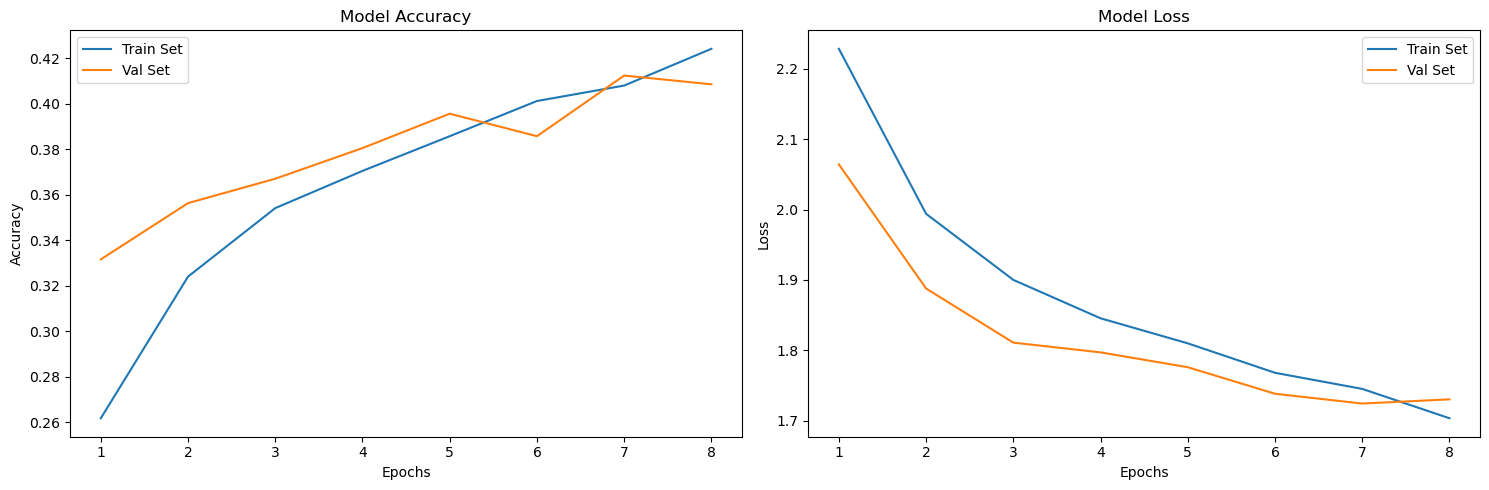

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Criação da matriz de confusão
y_val_classes = np.argmax(y_val.astype(int), axis=1)
conf_matrix = confusion_matrix(y_val_classes, y_pred_classes)

# Plotagem da matriz de confusão com Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(balanced_df['genre']), yticklabels=np.unique(balanced_df['genre']))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()